# نموذج تصنيف الأصوات - تمييز أصوات الكلاب والقطط

هذا النموذج يقوم بتصنيف الأصوات إلى فئتين:
* أصوات الكلاب
* أصوات القطط

In [ ]:
# تثبيت المكتبات المطلوبة
!pip install librosa tensorflow numpy scikit-learn pandas matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# استيراد المكتبات
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import scipy.signal as signal
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from sklearn.metrics import confusion_matrix

In [ ]:
class AdvancedAudioClassifier:
    def __init__(self, sr=22050, duration=3):
        self.sr = sr
        self.duration = duration
        self.model = None
        self.scaler = StandardScaler()

    def extract_features(self, audio):
        """استخراج مجموعة متنوعة من الخصائص الصوتية"""
        features = []

        # استخراج MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=self.sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        features.extend(mfccs_scaled)

        # استخراج الطيف الترددي
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_mean = np.mean(mel_spec_db.T, axis=0)
        features.extend(mel_spec_mean)

        # استخراج خصائص إضافية
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=self.sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.sr)[0]
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]

        features.extend([
            np.mean(spectral_centroids),
            np.std(spectral_centroids),
            np.mean(spectral_rolloff),
            np.std(spectral_rolloff),
            np.mean(zero_crossing_rate),
            np.std(zero_crossing_rate)
        ])

        return np.array(features)

    def augment_audio(self, audio):
        """تطبيق تقنيات متعددة لزيادة البيانات"""
        augmented = []
        augmented.append(audio)

        # تغيير السرعة
        augmented.append(librosa.effects.time_stretch(audio, rate=0.8))
        augmented.append(librosa.effects.time_stretch(audio, rate=1.2))

        # تغيير درجة الصوت
        augmented.append(librosa.effects.pitch_shift(audio, sr=self.sr, n_steps=2))
        augmented.append(librosa.effects.pitch_shift(audio, sr=self.sr, n_steps=-2))

        # إضافة ضوضاء
        noise_factor = 0.005
        noise = np.random.normal(0, 1, len(audio))
        augmented.append(audio + noise_factor * noise)

        return augmented

    def prepare_audio(self, audio_path):
        """تجهيز الملف الصوتي مع استخراج الخصائص وزيادة البيانات"""
        try:
            audio, _ = librosa.load(audio_path, sr=self.sr, duration=self.duration)
            audio = librosa.util.normalize(audio)

            # زيادة البيانات
            augmented_audios = self.augment_audio(audio)

            # استخراج الخصائص
            features_list = []
            for aug_audio in augmented_audios:
                features = self.extract_features(aug_audio)
                features_list.append(features)

            return np.array(features_list)
        except Exception as e:
            print(f"Error loading {audio_path}: {str(e)}")
            raise

    def build_model(self, input_shape):
        """بناء نموذج CNN متقدم"""
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Reshape((-1, 1)),

            # الكتلة الأولى
            layers.Conv1D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling1D(2),
            layers.Dropout(0.3),

            # الكتلة الثانية
            layers.Conv1D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling1D(2),
            layers.Dropout(0.3),

            # الطبقات المتصلة بالكامل
            layers.Flatten(),
            layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train(self, X_train, y_train, validation_split=0.2, epochs=50, batch_size=32):
        """تدريب النموذج"""
        if self.model is None:
            self.model = self.build_model(X_train.shape[1:])

        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )

        return history

In [ ]:
def collect_audio_files(directories):
    """جمع كل الملفات الصوتية من المجلدات المحددة"""
    audio_files = []
    for directory in directories:
        if os.path.exists(directory):
            if os.path.isdir(directory):
                files = [os.path.join(directory, f) for f in os.listdir(directory)
                        if f.endswith(('.wav', '.mp3'))]
                audio_files.extend(files)
    return audio_files

def check_directory_structure():
    """التحقق من هيكل المجلدات"""
    data_dirs = [
        "/content/drive/MyDrive/ESC-50-master",
        "/content/drive/MyDrive/combined_data",
        "/content/drive/MyDrive/dog_sounds",
        "/content/drive/MyDrive/cats"
    ]

    print("Checking Google Drive structure...")

    for data_dir in data_dirs:
        print(f"\n{'='*50}")
        print(f"Checking directory: {data_dir}")

        if os.path.exists(data_dir):
            print("✓ Directory exists")
            print("Contents:", os.listdir(data_dir))

            # التحقق من مجلد dogs
            dog_dir = os.path.join(data_dir, 'dogs')
            if os.path.exists(dog_dir):
                audio_files = [f for f in os.listdir(dog_dir) if f.endswith(('.wav', '.mp3'))]
                print(f"\nDogs directory:")
                print(f"✓ Found {len(audio_files)} audio files")
                if audio_files:
                    print("Sample files:", audio_files[:5])
            else:
                print("\n✗ Dogs directory not found")

            # التحقق من مجلد cats
            cat_dir = os.path.join(data_dir, 'cats')
            if os.path.exists(cat_dir):
                audio_files = [f for f in os.listdir(cat_dir) if f.endswith(('.wav', '.mp3'))]
                print(f"\nCats directory:")
                print(f"✓ Found {len(audio_files)} audio files")
                if audio_files:
                    print("Sample files:", audio_files[:5])
            else:
                print("\n✗ Cats directory not found")
        else:
            print("✗ Directory does not exist")

In [ ]:
# التحقق من هيكل المجلدات
check_directory_structure()

Checking Google Drive structure...

Checking directory: /content/drive/MyDrive/ESC-50-master
✓ Directory exists
Contents: ['meta', 'LICENSE', 'requirements.txt', 'README.md', 'pytest.ini', 'esc50.gif', 'tests', '.gitignore', '.circleci', '.github', 'audio']

✗ Dogs directory not found

✗ Cats directory not found

Checking directory: /content/drive/MyDrive/combined_data
✓ Directory exists
Contents: ['cats', 'dogs']

Dogs directory:
✓ Found 516 audio files
Sample files: ['1-100032-A-0.wav', '1-110389-A-0.wav', '1-30226-A-0.wav', '1-30344-A-0.wav', '1-32318-A-0.wav']

Cats directory:
✓ Found 438 audio files
Sample files: ['1-34094-A-5.wav', '1-34094-B-5.wav', '1-47819-A-5.wav', '1-47819-B-5.wav', '1-47819-C-5.wav']

Checking directory: /content/drive/MyDrive/dog_sounds
✓ Directory exists
Contents: ['479619__craigsmith__r01-13-dog-whimpering.wav', '62048__robinhood76__00488-dogs-behind-fence-1.wav', '649021__atomediadesign__dog-barking-in-forest-when-jogger-passend-by.wav', '418108__crazym

In [ ]:
# تهيئة المصنف
print("\nInitializing Audio Classifier...")
classifier = AdvancedAudioClassifier()

# تحديد مصادر البيانات
combined_data_dir = "/content/drive/MyDrive/combined_data"

dog_sources = [
    "/content/drive/MyDrive/dog_sounds",
    os.path.join(combined_data_dir, "dogs")
]

cat_sources = [
    "/content/drive/MyDrive/cats",
    os.path.join(combined_data_dir, "cats")
]

# جمع الملفات
print("\nCollecting audio files...")
dog_files = collect_audio_files(dog_sources)
cat_files = collect_audio_files(cat_sources)

print(f"Found {len(dog_files)} dog audio files")
print(f"Found {len(cat_files)} cat audio files")


Initializing Audio Classifier...

Found 562 dog audio files
Found 471 cat audio files


In [ ]:
# معالجة الملفات
X_all = []
y_all = []

# معالجة ملفات الكلاب
print("\nProcessing dog files...")
for file in dog_files:
    try:
        features = classifier.prepare_audio(file)
        X_all.extend(features)
        y_all.extend([1] * len(features))
        print(f"Processed: {os.path.basename(file)}")
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# معالجة ملفات القطط
print("\nProcessing cat files...")
for file in cat_files:
    try:
        features = classifier.prepare_audio(file)
        X_all.extend(features)
        y_all.extend([0] * len(features))
        print(f"Processed: {os.path.basename(file)}")
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# التحقق من وجود بيانات كافية
if len(X_all) == 0 or len(y_all) == 0:
    raise ValueError("No data was processed! Check your audio files.")

X_all = np.array(X_all)
y_all = np.array(y_all)

print("\nFinal Dataset Summary:")
print(f"Total samples: {len(X_all)}")
print(f"Dogs: {sum(y_all)} samples")
print(f"Cats: {len(y_all) - sum(y_all)} samples")


Processing dog files...
Processed: 479619__craigsmith__r01-13-dog-whimpering.wav
Processed: 62048__robinhood76__00488-dogs-behind-fence-1.wav
Processed: 649021__atomediadesign__dog-barking-in-forest-when-jogger-passend-by.wav
Processed: 418108__crazymonke9__dog-tripple-bark.wav
Processed: 418108__crazymonke9__dog-tripple-bark (1).wav
Processed: 612858__weakwero__dog.wav
Processed: 640726__iainmccurdy__dog-barking.wav
Processed: 656117__itsthegoodstuff__dog-barking.wav
Processed: 632306__dareecarrey__dog-distant-birds-a-crow-akg-p170.wav
Processed: 632306__dareecarrey__dog-distant-birds-a-crow-akg-p170 (1).wav
Processed: 420451__mrthenoronha__dogs-barking.wav
Processed: 523176__zajjman__blossom-bark-v3.wav
Processed: 692661__saha213131__bark.mp3
Processed: 420447__mrthenoronha__barking-4.wav
Processed: 770029__vrymaa__animal-dog-bark-2.wav
Processed: 121565__juskiddink__dogs-growling.wav
Processed: 595438__21100306__dogs-barking.wav
Processed: 233691__csengeri__dogs-fighting.mp3
Proces

In [ ]:
# تقسيم البيانات وتدريب النموذج
print("\nSplitting Dataset...")
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print("\nTraining Model...")
history = classifier.train(X_train, y_train)

print("\nEvaluating Model...")
test_loss, test_accuracy = classifier.model.evaluate(X_test, y_test)
print(f"Model Test Accuracy: {test_accuracy*100:.2f}%")


Splitting Dataset...

Training Model...
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.5924 - loss: 3.3916 - val_accuracy: 0.7097 - val_loss: 1.4338 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7233 - loss: 1.3573 - val_accuracy: 0.7208 - val_loss: 1.2640 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7508 - loss: 1.1575 - val_accuracy: 0.7016 - val_loss: 1.1467 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7778 - loss: 1.0454 - val_accuracy: 0.6774 - val_loss: 1.1080 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7840 - loss: 0.9820 - val_accuracy: 0.7097 - val_loss: 1.0295 - learning_rate: 0.0010
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8002 - loss: 0.9179 - val_accuracy: 0.7863 - val_loss: 0.9179 - learning_rate: 0.0010
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3

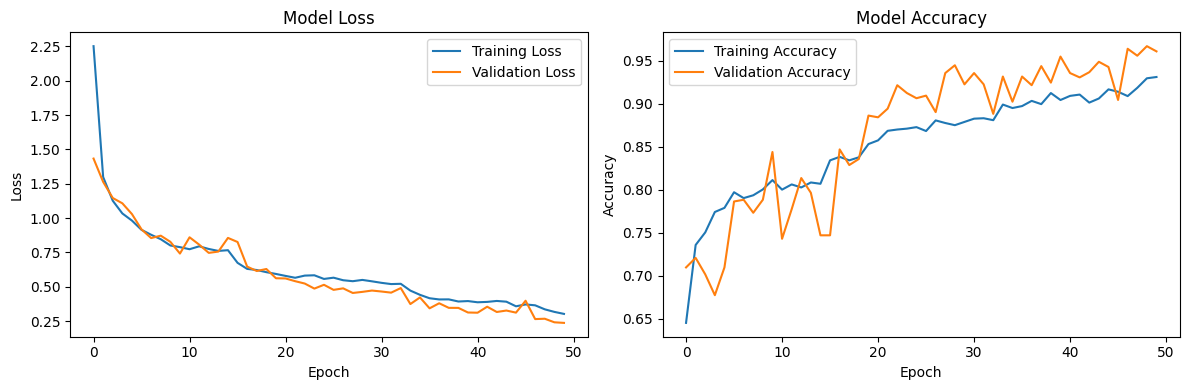

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


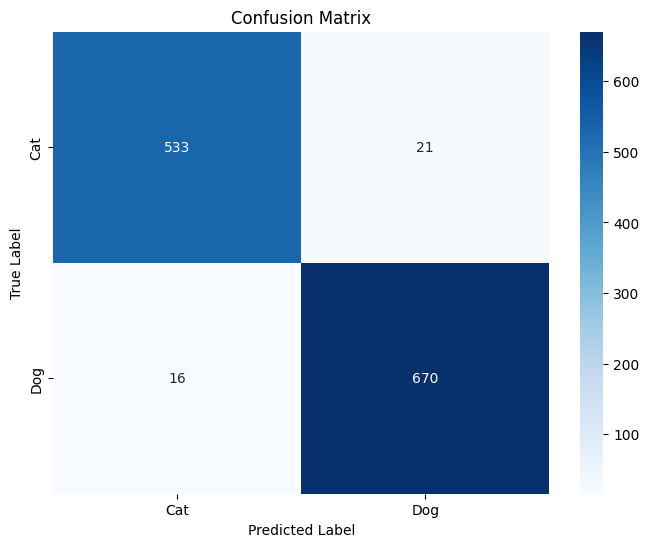

In [ ]:
# رسم منحنى التدريب
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# تثبيت المكتبات المطلوبة
!pip install seaborn scikit-learn

# استيراد المكتبات
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# احصل على التنبؤات
y_pred = (classifier.model.predict(X_test) > 0.5).astype(int)

# احسب مصفوفة الارتباك
cm = confusion_matrix(y_test, y_pred)

# ارسم المصفوفة
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Cat', 'Dog'])
plt.yticks([0.5, 1.5], ['Cat', 'Dog'])
plt.show()

Saving filtered_output (1).wav to filtered_output (1).wav
Loading audio file...

Original Audio:



Applying filter...

Filtered Audio:


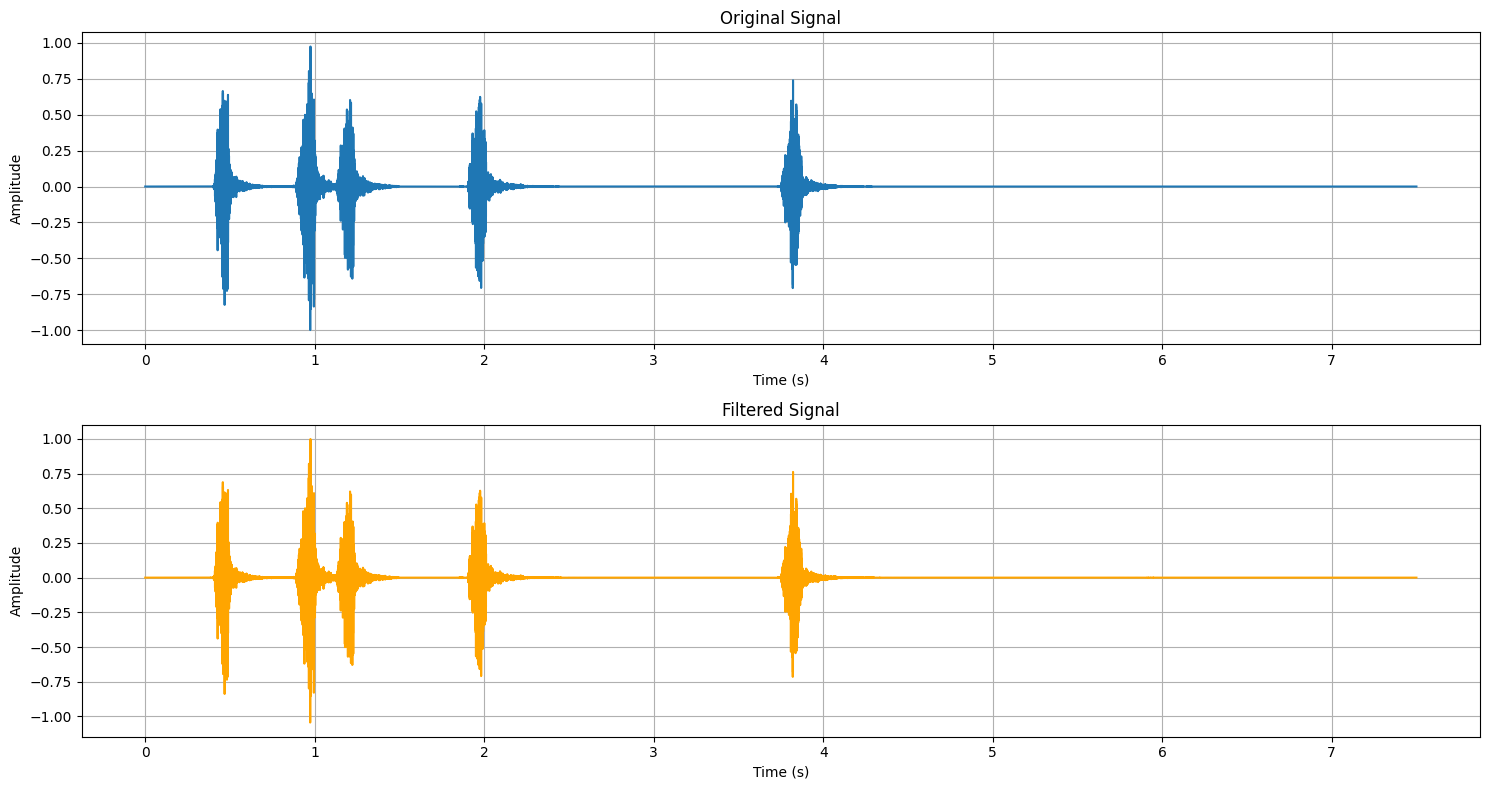

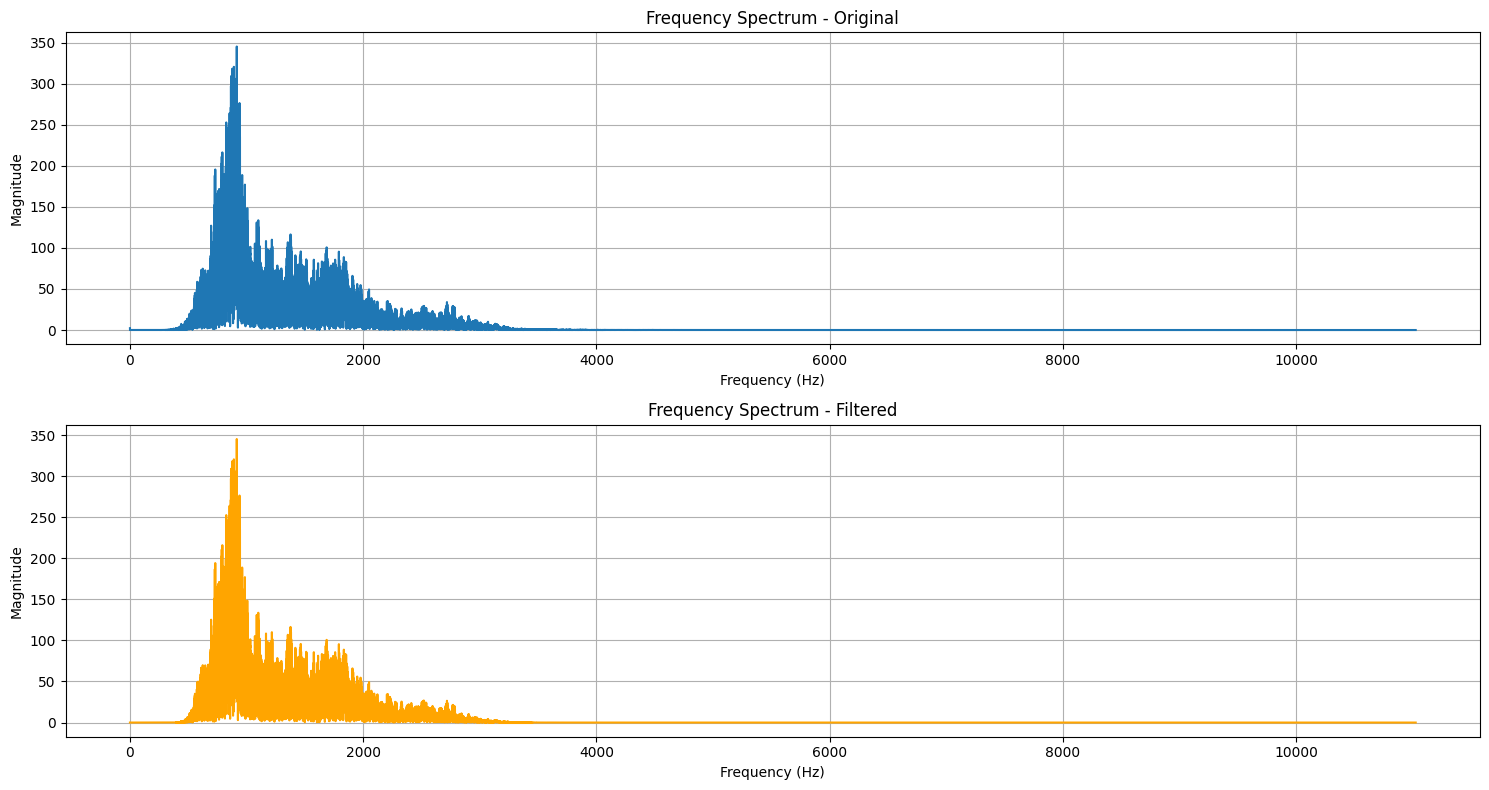

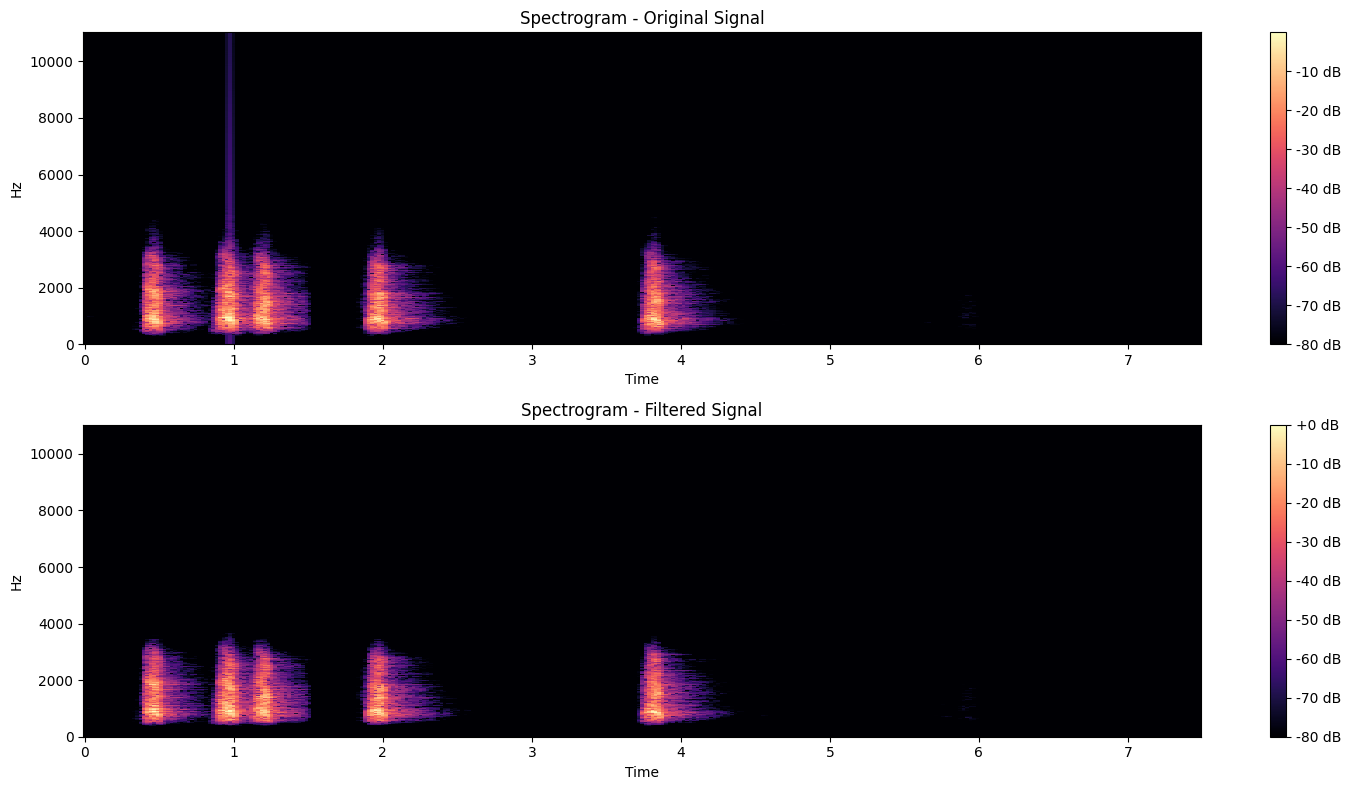

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import signal
import librosa.display
from IPython.display import Audio, display
import soundfile as sf

def process_and_play_audio(audio_file):
    # Load the audio file
    print("Loading audio file...")
    audio_data, sr = librosa.load(audio_file, sr=22050)

    # Play original audio
    print("\nOriginal Audio:")
    display(Audio(audio_data, rate=sr))

    # Apply bandpass filter
    print("\nApplying filter...")
    nyquist = sr // 2
    low = 500 / nyquist
    high = 3000 / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    filtered_audio = signal.filtfilt(b, a, audio_data)

    # Play filtered audio
    print("\nFiltered Audio:")
    display(Audio(filtered_audio, rate=sr))

    # Save filtered audio
    sf.write('filtered_output.wav', filtered_audio, sr)

    # Plot the signals
    time = np.arange(len(audio_data)) / sr

    # Plot 1: Original vs Filtered Time Domain Signals
    plt.figure(figsize=(15, 8))

    # Original signal
    plt.subplot(2, 1, 1)
    plt.plot(time, audio_data)
    plt.title('Original Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Filtered signal
    plt.subplot(2, 1, 2)
    plt.plot(time, filtered_audio, color='orange')
    plt.title('Filtered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot 2: Frequency Spectrum
    plt.figure(figsize=(15, 8))

    # Original spectrum
    plt.subplot(2, 1, 1)
    freq_orig = np.fft.rfftfreq(len(audio_data), 1/sr)
    fft_orig = np.abs(np.fft.rfft(audio_data))
    plt.plot(freq_orig, fft_orig)
    plt.title('Frequency Spectrum - Original')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)

    # Filtered spectrum
    plt.subplot(2, 1, 2)
    fft_filt = np.abs(np.fft.rfft(filtered_audio))
    plt.plot(freq_orig, fft_filt, color='orange')
    plt.title('Frequency Spectrum - Filtered')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot 3: Spectrograms
    plt.figure(figsize=(15, 8))

    # Original spectrogram
    plt.subplot(2, 1, 1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram - Original Signal')

    # Filtered spectrogram
    plt.subplot(2, 1, 2)
    D_filtered = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_audio)), ref=np.max)
    librosa.display.specshow(D_filtered, y_axis='linear', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram - Filtered Signal')

    plt.tight_layout()
    plt.show()

# Install required packages
!pip install librosa

# Upload your audio file
from google.colab import files
uploaded = files.upload()

# Get the filename of the uploaded file
filename = list(uploaded.keys())[0]

# Process the audio and show plots
process_and_play_audio(filename)

# Download the filtered audio
files.download('filtered_output.wav')